# ОИАД. Лабораторная работа №2

## Входные данные
Датасет: **datasets/students_simple.csv**
Выбираются 2 столбика данных по формулам:
1) $N \% 5$
2) $N^2 \% 5 + 5$
где $N$ - номер в списке

## 1. Расчет корреляций
1. Фехнера
2. Пирсона + доверительный интервал
3. Спирмена
4. Кенделла

## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)

## 3. Уравнение регрессии
Построить уравнение регрессии по видам:
1. линейная, $y=w_1 x + w_0$
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$
4. показательная, $y = w_1^x \cdot w_0$

Показать результаты на графиках

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие модели данным с помощью критерия Фишера

## 5. Выводы
Сделать вывод по каждому пункту

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log, exp
from scipy import stats

DATA_PATH = "students_simple.csv"

if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    note = f"Loaded {DATA_PATH} shape={df.shape}"
else:
    df = None
    note = f"{DATA_PATH} not found — using generated N=1..25"

In [12]:
N = 17
col1 = N % 5
col2 = (N**2) % 5 + 5

x = df.iloc[:,col1].to_numpy(dtype=float)
y = df.iloc[:,col2].to_numpy(dtype=float)
n = len(x)

In [4]:
# -------------------------
# 1. Корреляции
# -------------------------
def fechner_coefficient(x, y):
    sx = np.sign(x - np.mean(x)).astype(int)
    sy = np.sign(y - np.mean(y)).astype(int)
    return np.mean(sx * sy)

def pearson_ci(r, n, alpha=0.05):
    if n <= 3:
        return (np.nan, np.nan)
    z = 0.5 * np.log((1 + r) / (1 - r))
    se = 1.0 / (n - 3)**0.5
    z_crit = stats.norm.ppf(1 - alpha/2)
    lo_z, hi_z = z - z_crit * se, z + z_crit * se
    return (np.tanh(lo_z), np.tanh(hi_z))

r_fechner = fechner_coefficient(x, y)
r_pearson, p_pearson = stats.pearsonr(x, y)
pearson_lo, pearson_hi = pearson_ci(r_pearson, n)
rho_spearman, p_spearman = stats.spearmanr(x, y)
tau_kendall, p_kendall = stats.kendalltau(x, y)

print("\n--- Correlations ---")
print(f"Fechner: r_F = {r_fechner:.4f}")
print(f"Pearson: r = {r_pearson:.4f}, p = {p_pearson*100:.2f}%, 95% CI = ({pearson_lo:.4f}, {pearson_hi:.4f})")
print(f"Spearman: rho = {rho_spearman:.4f}, p = {p_spearman*100:.2f}%")
print(f"Kendall: tau = {tau_kendall:.6f}, p = {p_kendall*100:.2f}%")


--- Correlations ---
Fechner: r_F = -0.4000
Pearson: r = -0.5699, p = 0.87%, 95% CI = (-0.8085, -0.1703)
Spearman: rho = -0.5392, p = 1.42%
Kendall: tau = -0.436176, p = 0.77%


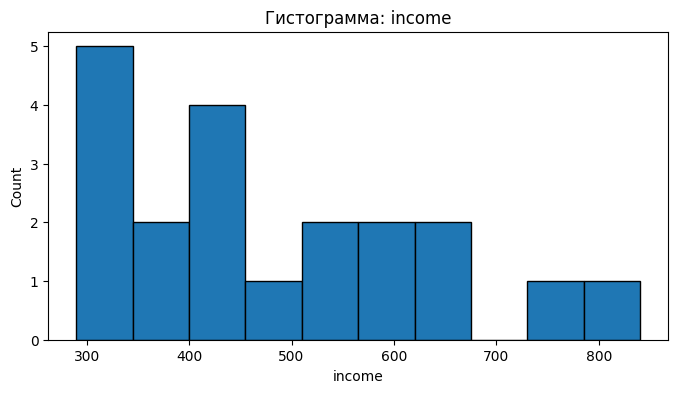

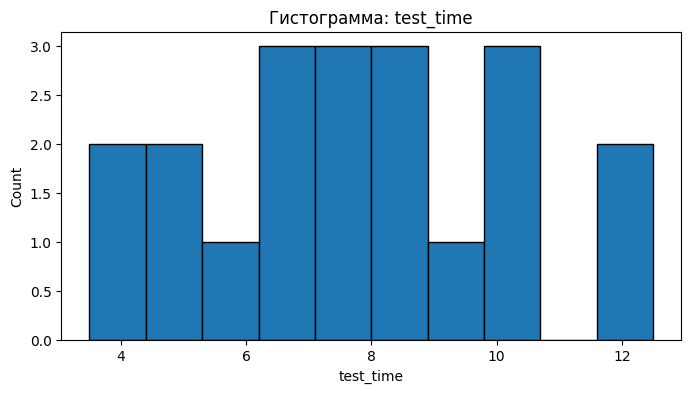

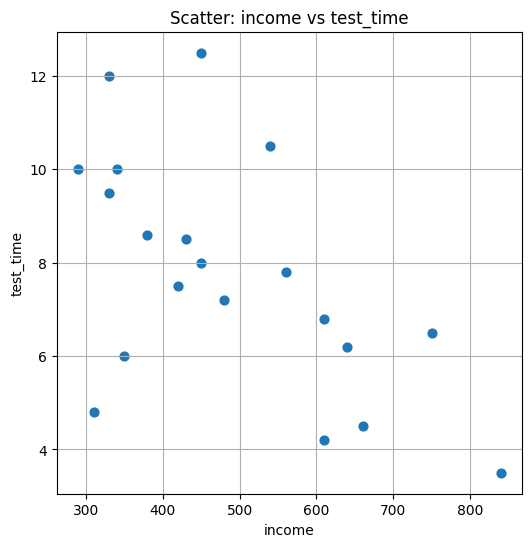

In [5]:
# -------------------------
# 2. Визуализация
# -------------------------
plt.figure(figsize=(8,4))
plt.hist(x, edgecolor='black')
plt.title(f"Гистограмма: {df.columns[col1]}")
plt.xlabel(df.columns[col1])
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(y, edgecolor='black')
plt.title(f"Гистограмма: {df.columns[col2]}")
plt.xlabel(df.columns[col2])
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(x, y, s=40)
plt.title(f"Scatter: {df.columns[col1]} vs {df.columns[col2]}")
plt.xlabel(df.columns[col1])
plt.ylabel(df.columns[col2])
plt.grid(True)

plt.show()

**Корреляция, очевидно, отутствует**


--- Regression summary ---
         model                                    formula        R2  \
0       linear              y = -0.009169 * x + 12.208888  0.324779   
1    quadratic  y = -0.000018 x^2 + 0.009697 x + 7.601723  0.354176   
2   hyperbolic               y = 1832.346540/x + 3.614860  0.242772   
3  exponential                 y = 0.998654^x * 14.121573  0.354759   

         SSE       MSE         F       p_F  
0  81.662564  4.083128  8.657943  0.008708  
1  78.107284  3.905364  4.661474  0.024320  
2  91.580702  4.579035  5.770903  0.027299  
3  86.109716  4.305486  8.968722  0.007773  


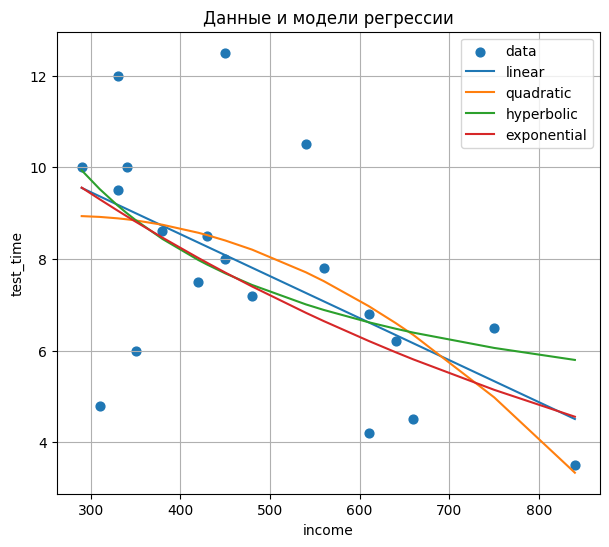

In [6]:
# -------------------------
# 3. Уравнение регрессии
# -------------------------
def regression_metrics(y_true, y_pred,p):
    n = len(y_true)
    residuals = y_true - y_pred
    SSE = float(np.sum(residuals**2)) # сумма квадратов ошибок

    y_mean = float(np.mean(y_true))
    SST = float(np.sum((y_true - y_mean)**2)) # общая сумма квадратов
    SSR = float(np.sum((y_pred - y_mean)**2))  # объяснённая вариация
    MSE = SSE / n
    R2 = SSR / SST
    F = (SSR/p) / (MSE*n/(n-p-1))
    p_F = stats.f.sf(F, p, (n-p-1))
    return {"SSE":SSE, "SSR":SSR, "SST":SST, "MSE":MSE, "R2":R2, "F":F, "p_F":p_F}

models = {}

# 3.1 Линейная
coeff_lin = np.polyfit(x, y, 1)  # [w1, w0]
w1_lin, w0_lin = coeff_lin
y_pred_lin = w1_lin * x + w0_lin
models['linear'] = {
    "name":"linear",
    "formula":f"y = {w1_lin:.6f} * x + {w0_lin:.6f}",
    "y_pred": y_pred_lin
}
models['linear'].update(regression_metrics(y, y_pred_lin,p=1))

# 3.2 Квадратичная
coeff_quad = np.polyfit(x, y, 2)  # [w2, w1, w0]
w2_q, w1_q, w0_q = coeff_quad
y_pred_quad = w2_q * x**2 + w1_q * x + w0_q
models['quadratic'] = {
    "name":"quadratic",
    "formula":f"y = {w2_q:.6f} x^2 + {w1_q:.6f} x + {w0_q:.6f}",
    "y_pred": y_pred_quad
}
models['quadratic'].update(regression_metrics(y, y_pred_quad,p=2))

# 3.3 Гиперболическая y = w1/x + w0

inv_x = 1.0/x
A = np.vstack([inv_x, np.ones_like(inv_x)]).T
w_hyp, *_ = np.linalg.lstsq(A, y)
w1_hyp, w0_hyp = w_hyp[0], w_hyp[1]
y_pred_hyp = w1_hyp * inv_x + w0_hyp
models['hyperbolic'] = {
    "name":"hyperbolic",
    "formula":f"y = {w1_hyp:.6f}/x + {w0_hyp:.6f}",
    "y_pred": y_pred_hyp
}
models['hyperbolic'].update(regression_metrics(y, y_pred_hyp,p=1))

# 3.4 Показательная y = w1^x * w0  -> ln y = x ln w1 + ln w0
# Требует y > 0

ln_y = np.log(y)
slope, intercept = np.polyfit(x, ln_y,deg=1)
ln_w1 = slope
ln_w0 = intercept
w1_exp = np.exp(ln_w1)
w0_exp = np.exp(ln_w0)
y_pred_exp = (w1_exp ** x) * w0_exp
models['exponential'] = {
    "name":"exponential",
    "formula":f"y = {w1_exp:.6f}^x * {w0_exp:.6f}",
    "y_pred": y_pred_exp
}
models['exponential'].update(regression_metrics(y, y_pred_exp,p=1))


# -------------------------
# 3.5 Вывод сводки моделей
# -------------------------
summary_rows = []
for k, v in models.items():
    summary_rows.append({
        "model": v["name"],
        "formula": v["formula"],
        "R2": v["R2"],
        "SSE": v["SSE"],
        "MSE": v["MSE"],
        "F":v["F"],
        "p_F":v["p_F"]
    })

summary_df = pd.DataFrame(summary_rows)
print("\n--- Regression summary ---")
print(summary_df)

# -------------------------
# 3.6 Построение графиков: данные + предсказания
# -------------------------
plt.figure(figsize=(7,6))
plt.scatter(x, y, label="data", s=40)
# Упорядочим точки по x для корректного отображения линий
order = np.argsort(x)
xs = x[order]

for k, v in models.items():
    ypred = v["y_pred"][order]

    if not np.all(np.isnan(ypred)):
        plt.plot(xs, ypred, label=v["name"])
plt.title("Данные и модели регрессии")
plt.xlabel(df.columns[col1])
plt.ylabel(df.columns[col2])
plt.legend()
plt.grid(True)
plt.show()

**Апроксимация, очевидно, не получилась**


--- Best model ---
{'model': 'exponential', 'formula': 'y = 0.998654^x * 14.121573', 'R2': 0.35475870437284446, 'SSE': 86.10971564456622, 'MSE': 4.3054857822283115, 'F': 8.968721871344654, 'p_F': 0.007773093087742444}

--- Worst model ---
{'model': 'hyperbolic', 'formula': 'y = 1832.346540/x + 3.614860', 'R2': 0.24277172406433378, 'SSE': 91.58070214821132, 'MSE': 4.579035107410566, 'F': 5.770903137179302, 'p_F': 0.027299336179869876}


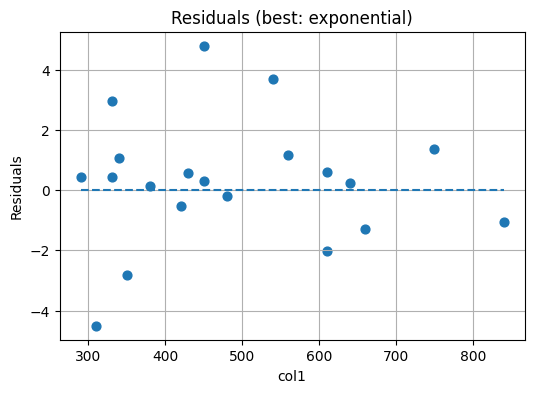

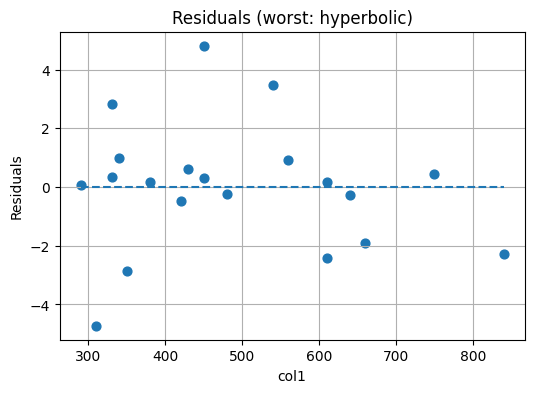

In [7]:
# -------------------------
# 4. Проверка уравнения регрессии: F-критерий (лучшее и худшее по R2)
# -------------------------
best = summary_df.sort_values("R2",ascending=False).iloc[0]
worst = summary_df.sort_values("R2",ascending=False).iloc[-1]
print("\n--- Best model ---")
print(best.to_dict())
print("\n--- Worst model ---")
print(worst.to_dict())

# Построим графики остатков для лучшей и худшей модели
def plot_residuals(x, y, y_pred, title):
    res = y - y_pred
    plt.figure(figsize=(6,4))
    plt.scatter(x, res, s=40)
    plt.hlines(0, xmin=min(x), xmax=max(x), linestyles='dashed')
    plt.title(title)
    plt.xlabel("col1")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.show()

# Best residuals
best_model = models[best['model']]
if not np.all(np.isnan(best_model['y_pred'])):
    plot_residuals(x, y, best_model['y_pred'], f"Residuals (best: {best_model['name']})")

# Worst residuals
worst_model = models[worst['model']]
if not np.all(np.isnan(worst_model['y_pred'])):
    plot_residuals(x, y, worst_model['y_pred'], f"Residuals (worst: {worst_model['name']})")